In [97]:
import os
#import jovian
import matplotlib
import opendatasets as od
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px
%matplotlib inline
sns.set_style('darkgrid')
matplotlib.rcParams['font.size'] = 14
matplotlib.rcParams['figure.figsize'] = (10, 6)
matplotlib.rcParams['figure.facecolor'] = '#00000000'

In [98]:
df_boxes = pd.read_csv('boxes.csv') #importing box details datasets
df_problem1 = pd.read_csv('problem 3.csv') #importing predict datasets
df_purchase = pd.read_csv('purchase.csv') #importing history datasets

## Data Cleaning

In [99]:
nan_counts = df_purchase.isnull().sum()
print(nan_counts)

PURCHASE_DATE     0
MAGIC_KEY         0
BOX_ID           47
BOX_COUNT        47
dtype: int64


In [100]:
BOX_ID_Mode = df_purchase['BOX_ID'].mode()[0]
mean_box_count = df_purchase['BOX_COUNT'].mean()

# Fill NaN values with mean values
df_purchase['BOX_ID'].fillna(BOX_ID_Mode, inplace=True)
df_purchase['BOX_COUNT'].fillna(mean_box_count, inplace=True)

In [101]:
nan_counts = df_purchase.isnull().sum()
print(nan_counts)

PURCHASE_DATE    0
MAGIC_KEY        0
BOX_ID           0
BOX_COUNT        0
dtype: int64


In [102]:
# Fill missing values for the magic ID '290D33249B7' with previous data
df_purchase.loc[df_purchase['MAGIC_KEY'] == '290D33249B7', ['BOX_ID', 'BOX_COUNT']] = df_purchase.loc[df_purchase['MAGIC_KEY'] == '290D33249B7', ['BOX_ID', 'BOX_COUNT']].fillna(method='ffill')

C:\Users\USER\AppData\Local\Temp\ipykernel_4924\1714574754.py:2: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  df_purchase.loc[df_purchase['MAGIC_KEY'] == '290D33249B7', ['BOX_ID', 'BOX_COUNT']] = df_purchase.loc[df_purchase['MAGIC_KEY'] == '290D33249B7', ['BOX_ID', 'BOX_COUNT']].fillna(method='ffill')


In [103]:
merged_df = df_boxes.merge(df_purchase, on='BOX_ID', how='inner')

In [104]:
merged_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2455847 entries, 0 to 2455846
Data columns (total 9 columns):
 #   Column           Dtype  
---  ------           -----  
 0   BOX_ID           int64  
 1   QUALITY          object 
 2   DELIVERY_OPTION  object 
 3   MILK             float64
 4   MEAT             float64
 5   UNIT_PRICE       float64
 6   PURCHASE_DATE    object 
 7   MAGIC_KEY        object 
 8   BOX_COUNT        float64
dtypes: float64(4), int64(1), object(4)
memory usage: 168.6+ MB


In [105]:
total_unique_box_id = merged_df['BOX_ID'].nunique()

print("Total unique BOX_ID:", total_unique_box_id)

Total unique BOX_ID: 290


In [106]:
total_unique_magic_key = merged_df['MAGIC_KEY'].nunique()

print("Total unique BOX_ID:", total_unique_magic_key)

Total unique BOX_ID: 1274101


## data cleaning

In [107]:
round(df_purchase.describe())

,BOX_ID,BOX_COUNT
count,2455864.0,2455864.0
mean,231.0,1.0
std,29233.0,0.0
min,1.0,-1.0
25%,106.0,1.0
50%,143.0,1.0
75%,215.0,1.0
max,11111111.0,19.0


In [108]:
round(merged_df.describe())

,BOX_ID,MILK,MEAT,UNIT_PRICE,BOX_COUNT
count,2455847.0,2455847.0,2455847.0,2455847.0,2455847.0
mean,154.0,8.0,2.0,18.0,1.0
std,70.0,6.0,1.0,4.0,0.0
min,1.0,0.0,0.0,6.0,1.0
25%,106.0,0.0,2.0,14.0,1.0
50%,143.0,10.0,2.0,18.0,1.0
75%,215.0,11.0,2.0,20.0,1.0
max,290.0,24.0,6.0,24.0,19.0


In [109]:
merged_df.duplicated().sum()

77

In [110]:
# drop duplicates rows
merged_df= merged_df.drop_duplicates()

In [111]:
from scipy import stats

z_scores = np.abs(stats.zscore(df_purchase['BOX_COUNT']))
threshold = 3
outliers = np.where(z_scores > threshold)[0]
print("Outliers detected using Z-score method:", outliers)

In [112]:
merged_df.head()

,BOX_ID,QUALITY,DELIVERY_OPTION,MILK,MEAT,UNIT_PRICE,PURCHASE_DATE,MAGIC_KEY,BOX_COUNT
0,1,Premium,Home Delivery - CoD,0.0,2.7,9.96,4/2/2019,2C88D36D1FC,1.0
1,2,Premium,Home Delivery - CoD,0.0,2.3,11.96,2/1/2019,2BF011BDB38,1.0
2,2,Premium,Home Delivery - CoD,0.0,2.3,11.96,2/1/2019,2CA0EE8F2B3,1.0
3,2,Premium,Home Delivery - CoD,0.0,2.3,11.96,2/1/2019,2C623730B09,1.0
4,2,Premium,Home Delivery - CoD,0.0,2.3,11.96,2/1/2019,2CA6CE1054F,1.0


In [113]:
merged_df['PURCHASE_DATE'] = pd.to_datetime(merged_df['PURCHASE_DATE'], format="%d/%m/%Y")

In [114]:
#merged_df.PURCHASE_DATE.min(), merged_df.PURCHASE_DATE.max()

In [115]:
merged_df.PURCHASE_DATE.info()

<class 'pandas.core.series.Series'>
Index: 2455770 entries, 0 to 2455846
Series name: PURCHASE_DATE
Non-Null Count    Dtype         
--------------    -----         
2455770 non-null  datetime64[ns]
dtypes: datetime64[ns](1)
memory usage: 37.5 MB


# feature engineering

In [116]:
# Group the data by MAGIC_KEY and calculate the sum of MEAT purchased by each Magic Key
magic_key_meat = merged_df.groupby('MAGIC_KEY')['MEAT'].sum().reset_index(name= 'TOTAL_MEAT')

# Count the frequency of purchases made by each Magic Key
magic_key_purchase_frequency = merged_df.groupby('MAGIC_KEY').size().reset_index(name='PURCHASE_FREEQUENCY')

# Merge the two DataFrames on MAGIC_KEY
magic_key_data = pd.merge(magic_key_meat, magic_key_purchase_frequency, on='MAGIC_KEY')

# Display the resulting DataFrame
print(magic_key_data)

           MAGIC_KEY  TOTAL_MEAT  PURCHASE_FREEQUENCY
0        249670911D8         2.4                    2
1        249751FC4DD         1.8                    1
2        24978027606         2.9                    1
3        24979164422         2.5                    1
4        2497B8B4FDA         5.4                    2
...              ...         ...                  ...
1274096  2E6F72C6F1C         4.8                    3
1274097  2E6F8194908         2.4                    1
1274098  2E6F9C7B9B4         2.2                    1
1274099  2E6FB0EBB32        12.8                    6
1274100  2E6FBE224FA         2.7                    1

[1274101 rows x 3 columns]


In [117]:
# Assuming MAGIC_KEY is the common column between merged_df and magic_key_data
merged_df = pd.merge(merged_df, magic_key_data, on='MAGIC_KEY', how='left')


In [118]:
merged_df

,BOX_ID,QUALITY,DELIVERY_OPTION,MILK,MEAT,UNIT_PRICE,PURCHASE_DATE,MAGIC_KEY,BOX_COUNT,TOTAL_MEAT,PURCHASE_FREEQUENCY
0,1,Premium,Home Delivery - CoD,0.0,2.7,9.96,2019-02-04,2C88D36D1FC,1.0,2.7,1
1,2,Premium,Home Delivery - CoD,0.0,2.3,11.96,2019-01-02,2BF011BDB38,1.0,4.8,2
2,2,Premium,Home Delivery - CoD,0.0,2.3,11.96,2019-01-02,2CA0EE8F2B3,1.0,2.3,1
3,2,Premium,Home Delivery - CoD,0.0,2.3,11.96,2019-01-02,2C623730B09,1.0,4.7,2
4,2,Premium,Home Delivery - CoD,0.0,2.3,11.96,2019-01-02,2CA6CE1054F,1.0,2.3,1
...,...,...,...,...,...,...,...,...,...,...,...
2455765,289,Standard,Home Delivery - Digital Payment,0.0,4.7,15.96,2019-02-18,29149CE828C,1.0,33.9,13
2455766,290,Standard,Home Delivery - Digital Payment,12.0,1.8,19.98,2019-02-20,28FF7857D43,1.0,1.8,1
2455767,290,Standard,Home Delivery - Digital Payment,12.0,1.8,19.98,2019-01-05,28F675D813E,1.0,1.8,1
2455768,290,Standard,Home Delivery - Digital Payment,12.0,1.8,19.98,2019-01-11,29D99F43873,1.0,29.9,9


## Let's also parse the date column

## extracting Day, Month, Year from the dataset and making new columns of them

In [119]:
merged_df['DAY'] = merged_df['PURCHASE_DATE'].dt.day
merged_df['MONTH'] = merged_df['PURCHASE_DATE'].dt.month
merged_df['YEAR'] = merged_df['PURCHASE_DATE'].dt.year

## adding month wise purchase 

In [120]:
## this is the cols of first 15 dayas of meat purchase  and last 15 days of meat purchase from oct to feb




# # Function to create purchase columns for a specific month and year
# def create_purchase_columns(df, month, year):
#     # Filter the DataFrame to include only the rows with purchase dates in the specified month and year
#     filtered_df = merged_df[(merged_df['PURCHASE_DATE'].dt.year == year) & 
#                             (merged_df['PURCHASE_DATE'].dt.month == month)]
    
#     # Further filter the DataFrame to include only the rows with purchase dates within the first 15 days or last 15 days of the month
#     first_15_days_df = filtered_df[filtered_df['PURCHASE_DATE'].dt.day <= 15]
#     last_15_days_df = filtered_df[filtered_df['PURCHASE_DATE'].dt.day > 15]
    
#     # Group the filtered DataFrame by "MAGIC_KEY" and sum the "MEAT" column for each group
#     first_15_days_purchases = first_15_days_df.groupby('MAGIC_KEY')['MEAT'].sum()
#     last_15_days_purchases = last_15_days_df.groupby('MAGIC_KEY')['MEAT'].sum()
    
#     # Create new columns based on the total meat purchased by each Magic Key in the specified time periods
#     col_first_purchase = f"{month:02d}_FIRST_PURCHASE_{year}"
#     col_last_purchase = f"{month:02d}_LAST_PURCHASE_{year}"
    
#     merged_df[col_first_purchase] = 0
#     merged_df.loc[merged_df['MAGIC_KEY'].isin(first_15_days_purchases.index), col_first_purchase] = first_15_days_purchases
    
#     merged_df[col_last_purchase] = 0
#     merged_df.loc[merged_df['MAGIC_KEY'].isin(last_15_days_purchases.index), col_last_purchase] = last_15_days_purchases

# # Create purchase columns for each month and year from November 2018 to February 2019
# for month, year in [(10, 2018),(11, 2018), (12, 2018), (1, 2019), (2, 2019)]:
#     create_purchase_columns(merged_df, month, year)


In [121]:
# Create a pivot table to calculate the total meat purchased by each magic key in each month
monthly_meat_purchases = merged_df.pivot_table(index='MAGIC_KEY', columns=merged_df['PURCHASE_DATE'].dt.month, values='MEAT', aggfunc='sum')

# Rename the columns to represent the respective months
monthly_meat_purchases.columns = ['OCT_MEAT', 'NOV_MEAT', 'DEC_MEAT', 'JAN_MEAT', 'FEB_MEAT']

# Reset the index to convert the MAGIC_KEY back to a column
monthly_meat_purchases.reset_index(inplace=True)

# Fill NaN values with 0
monthly_meat_purchases.fillna(0, inplace=True)

# Display the resulting DataFrame
#print(monthly_meat_purchases)


In [122]:
merged_df = pd.merge(merged_df, monthly_meat_purchases, on='MAGIC_KEY', how='left')

In [123]:
#merged_df

In [124]:
# Function to create purchase columns for a specific month and year
def create_purchase_columns(df, month, year):
    # Filter the DataFrame to include only the rows with purchase dates in the specified month and year
    filtered_df = merged_df[(merged_df['PURCHASE_DATE'].dt.year == year) & 
                            (merged_df['PURCHASE_DATE'].dt.month == month)]
    
    # Further filter the DataFrame to include only the rows with purchase dates within the first 15 days or last 15 days of the month
    first_15_days_df = filtered_df[filtered_df['PURCHASE_DATE'].dt.day <= 15]
    last_15_days_df = filtered_df[filtered_df['PURCHASE_DATE'].dt.day > 15]
    
    # Group the filtered DataFrame by "MAGIC_KEY" and sum the "MEAT" column for each group
    first_15_days_purchases = first_15_days_df.groupby('MAGIC_KEY')['MEAT'].sum()
    last_15_days_purchases = last_15_days_df.groupby('MAGIC_KEY')['MEAT'].sum()
    
    # Create new columns based on the total meat purchased by each Magic Key in the specified time periods
    col_first_purchase = f"{month:02d}_FIRST_PURCHASE_{year}"
    col_last_purchase = f"{month:02d}_LAST_PURCHASE_{year}"
    
    df[col_first_purchase] = 0
    df.loc[df['MAGIC_KEY'].isin(first_15_days_purchases.index), col_first_purchase] = first_15_days_purchases
    df[col_first_purchase].fillna(0, inplace=True)  # Replace NaN with 0
    
    df[col_last_purchase] = 0
    df.loc[df['MAGIC_KEY'].isin(last_15_days_purchases.index), col_last_purchase] = last_15_days_purchases
    df[col_last_purchase].fillna(0, inplace=True)  # Replace NaN with 0

# Create purchase columns for each month and year from November 2018 to February 2019
for month, year in [(10, 2018), (11, 2018), (12, 2018), (1, 2019), (2, 2019)]:
    create_purchase_columns(merged_df, month, year)


In [125]:
# adding column of purchase duration
# Calculate the purchase duration
merged_df['PURCHASE_DURATION'] = merged_df.groupby('MAGIC_KEY')['PURCHASE_DATE'].diff().dt.days.fillna(0).abs()


# Calculate the mean of the 'MEAT' column
meat_mean = merged_df['MEAT'].mean()

# Fill missing values in the 'MEAT' column with the mean
merged_df['MEAT'].fillna(meat_mean, inplace=True)

merged_df['AVG_MEAT_PURCHASE'] = merged_df.groupby('MAGIC_KEY')['MEAT'].transform('mean')

merged_df['PURCHASE_DAY_OF_WEEK'] = merged_df['PURCHASE_DATE'].dt.dayofweek


# Include previous purchase quantity of meat for each 'MAGIC_KEY' with forward fill
merged_df['PREVIOUS_MEAT_QUANTITY'] = merged_df.groupby('MAGIC_KEY')['MEAT'].shift(1).fillna(method='ffill')


# Compute mean, median, and standard deviation of meat purchases per 'MAGIC_KEY'
merged_df['MEAT_MEAN'] = merged_df.groupby('MAGIC_KEY')['MEAT'].transform('mean')
merged_df['MEAT_MEDIAN'] = merged_df.groupby('MAGIC_KEY')['MEAT'].transform('median')






C:\Users\USER\AppData\Local\Temp\ipykernel_4924\3440360063.py:18: FutureWarning: Series.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  merged_df['PREVIOUS_MEAT_QUANTITY'] = merged_df.groupby('MAGIC_KEY')['MEAT'].shift(1).fillna(method='ffill')


In [126]:
merged_df

,BOX_ID,QUALITY,DELIVERY_OPTION,MILK,MEAT,UNIT_PRICE,PURCHASE_DATE,MAGIC_KEY,BOX_COUNT,TOTAL_MEAT,...,01_FIRST_PURCHASE_2019,01_LAST_PURCHASE_2019,02_FIRST_PURCHASE_2019,02_LAST_PURCHASE_2019,PURCHASE_DURATION,AVG_MEAT_PURCHASE,PURCHASE_DAY_OF_WEEK,PREVIOUS_MEAT_QUANTITY,MEAT_MEAN,MEAT_MEDIAN
0,1,Premium,Home Delivery - CoD,0.0,2.7,9.96,2019-02-04,2C88D36D1FC,1.0,2.7,...,0.0,0.0,0.0,0.0,0.0,2.700000,0,NaN,2.700000,2.70
1,2,Premium,Home Delivery - CoD,0.0,2.3,11.96,2019-01-02,2BF011BDB38,1.0,4.8,...,0.0,0.0,0.0,0.0,0.0,2.400000,2,NaN,2.400000,2.40
2,2,Premium,Home Delivery - CoD,0.0,2.3,11.96,2019-01-02,2CA0EE8F2B3,1.0,2.3,...,0.0,0.0,0.0,0.0,0.0,2.300000,2,NaN,2.300000,2.30
3,2,Premium,Home Delivery - CoD,0.0,2.3,11.96,2019-01-02,2C623730B09,1.0,4.7,...,0.0,0.0,0.0,0.0,0.0,2.350000,2,NaN,2.350000,2.35
4,2,Premium,Home Delivery - CoD,0.0,2.3,11.96,2019-01-02,2CA6CE1054F,1.0,2.3,...,0.0,0.0,0.0,0.0,0.0,2.300000,2,NaN,2.300000,2.30
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2455765,289,Standard,Home Delivery - Digital Payment,0.0,4.7,15.96,2019-02-18,29149CE828C,1.0,33.9,...,0.0,0.0,0.0,0.0,1.0,2.607692,0,3.6,2.607692,2.90
2455766,290,Standard,Home Delivery - Digital Payment,12.0,1.8,19.98,2019-02-20,28FF7857D43,1.0,1.8,...,0.0,0.0,0.0,0.0,0.0,1.800000,2,3.6,1.800000,1.80
2455767,290,Standard,Home Delivery - Digital Payment,12.0,1.8,19.98,2019-01-05,28F675D813E,1.0,1.8,...,0.0,0.0,0.0,0.0,0.0,1.800000,5,3.6,1.800000,1.80
2455768,290,Standard,Home Delivery - Digital Payment,12.0,1.8,19.98,2019-01-11,29D99F43873,1.0,29.9,...,0.0,0.0,0.0,0.0,77.0,3.322222,4,3.6,3.322222,3.60


In [127]:
# #---------------------------------------------------OCOTBER------------------------------------------

# # Filter the DataFrame to include only the rows with purchase dates in October 2018
# october_2018_df = merged_df[(merged_df['PURCHASE_DATE'].dt.year == 2018) & 
#                              (merged_df['PURCHASE_DATE'].dt.month == 10)]

# # Further filter the DataFrame to include only the rows with purchase dates within the first 15 days of October 2018
# october_2018_first_15_days_df = october_2018_df[october_2018_df['PURCHASE_DATE'].dt.day <= 15]

# # Group the filtered DataFrame by "MAGIC_KEY" and check if any purchase of MILK or MEAT is made by each Magic Key
# october_2018_first_15_days_purchases = october_2018_first_15_days_df.groupby('MAGIC_KEY')[['MILK', 'MEAT']].sum()

# # Create the new column "10_FIRST_PURCHASE_2018" based on whether a purchase is made by each Magic Key
# merged_df['10_FIRST_PURCHASE_2018'] = 0
# merged_df.loc[merged_df['MAGIC_KEY'].isin(october_2018_first_15_days_purchases.index), '10_FIRST_PURCHASE_2018'] = 1


# #---------------------------------------------------------------------------------------------------------------------------

# # Filter the DataFrame to include only the rows with purchase dates in October 2018
# october_2018_df = merged_df[(merged_df['PURCHASE_DATE'].dt.year == 2018) & 
#                              (merged_df['PURCHASE_DATE'].dt.month == 10)]

# # Further filter the DataFrame to include only the rows with purchase dates within the first 15 days of October 2018
# october_2018_last_15_days_df = october_2018_df[october_2018_df['PURCHASE_DATE'].dt.day > 15]

# # Group the filtered DataFrame by "MAGIC_KEY" and check if any purchase of MILK or MEAT is made by each Magic Key
# october_2018_last_15_days_purchases = october_2018_last_15_days_df.groupby('MAGIC_KEY')[['MILK', 'MEAT']].sum()

# # Create the new column "10_FIRST_PURCHASE_2018" based on whether a purchase is made by each Magic Key
# merged_df['10_LAST_PURCHASE_2018'] = 0
# merged_df.loc[merged_df['MAGIC_KEY'].isin(october_2018_last_15_days_purchases.index), '10_LAST_PURCHASE_2018'] = 1


# #_____________________________________________________________ NOVEMBER------------------------------

# # Filter the DataFrame to include only the rows with purchase dates in November 2018
# november_2018_df = merged_df[(merged_df['PURCHASE_DATE'].dt.year == 2018) & 
#                              (merged_df['PURCHASE_DATE'].dt.month == 11)]

# # Further filter the DataFrame to include only the rows with purchase dates within the first 15 days of November 2018
# november_2018_first_15_days_df = november_2018_df[november_2018_df['PURCHASE_DATE'].dt.day <= 15]

# # Group the filtered DataFrame by "MAGIC_KEY" and check if any purchase of MILK or MEAT is made by each Magic Key
# november_2018_first_15_days_purchases = november_2018_first_15_days_df.groupby('MAGIC_KEY')[['MILK', 'MEAT']].sum()

# # Create the new column "11_FIRST_PURCHASE_2018" based on whether a purchase is made by each Magic Key
# merged_df['11_FIRST_PURCHASE_2018'] = 0
# merged_df.loc[merged_df['MAGIC_KEY'].isin(november_2018_first_15_days_purchases.index), '11_FIRST_PURCHASE_2018'] = 1


# #---------------------------------------------------------------------------------------------------------------------------

# # Filter the DataFrame to include only the rows with purchase dates in November 2018
# november_2018_df = merged_df[(merged_df['PURCHASE_DATE'].dt.year == 2018) & 
#                              (merged_df['PURCHASE_DATE'].dt.month == 11)]

# # Further filter the DataFrame to include only the rows with purchase dates within the first 15 days of November 2018
# november_2018_first_15_days_df = november_2018_df[november_2018_df['PURCHASE_DATE'].dt.day > 15]

# # Group the filtered DataFrame by "MAGIC_KEY" and check if any purchase of MILK or MEAT is made by each Magic Key
# november_2018_last_15_days_purchases = november_2018_first_15_days_df.groupby('MAGIC_KEY')[['MILK', 'MEAT']].sum()

# # Create the new column "11_FIRST_PURCHASE_2018" based on whether a purchase is made by each Magic Key
# merged_df['11_LAST_PURCHASE_2018'] = 0
# merged_df.loc[merged_df['MAGIC_KEY'].isin(november_2018_first_15_days_purchases.index), '11_LAST_PURCHASE_2018'] = 1


# #------------------------------------------------------- DECEMBER---------------------------------------------

# # Filter the DataFrame to include only the rows with purchase dates in December 2018
# december_2018_df = merged_df[(merged_df['PURCHASE_DATE'].dt.year == 2018) & 
#                              (merged_df['PURCHASE_DATE'].dt.month == 11)]

# # Further filter the DataFrame to include only the rows with purchase dates within the first 15 days of december 2018
# december_2018_first_15_days_df = december_2018_df[december_2018_df['PURCHASE_DATE'].dt.day <= 15]

# # Group the filtered DataFrame by "MAGIC_KEY" and check if any purchase of MILK or MEAT is made by each Magic Key
# december_2018_first_15_days_purchases = december_2018_first_15_days_df.groupby('MAGIC_KEY')[['MILK', 'MEAT']].sum()

# # Create the new column "11_FIRST_PURCHASE_2018" based on whether a purchase is made by each Magic Key
# merged_df['12_FIRST_PURCHASE_2018'] = 0
# merged_df.loc[merged_df['MAGIC_KEY'].isin(december_2018_first_15_days_purchases.index), '12_FIRST_PURCHASE_2018'] = 1

# #---------------------------------------------------------------------------------------------------------------------

# # Filter the DataFrame to include only the rows with purchase dates in December 2018
# december_2018_df = merged_df[(merged_df['PURCHASE_DATE'].dt.year == 2018) & 
#                              (merged_df['PURCHASE_DATE'].dt.month == 11)]

# # Further filter the DataFrame to include only the rows with purchase dates within the first 15 days of december 2018
# december_2018_last_15_days_df = december_2018_df[december_2018_df['PURCHASE_DATE'].dt.day > 15]

# # Group the filtered DataFrame by "MAGIC_KEY" and check if any purchase of MILK or MEAT is made by each Magic Key
# december_2018_last_15_days_purchases = december_2018_last_15_days_df.groupby('MAGIC_KEY')[['MILK', 'MEAT']].sum()

# # Create the new column "11_FIRST_PURCHASE_2018" based on whether a purchase is made by each Magic Key
# merged_df['12_LAST_PURCHASE_2018'] = 0
# merged_df.loc[merged_df['MAGIC_KEY'].isin(december_2018_last_15_days_purchases.index), '12_LAST_PURCHASE_2018'] = 1



# #---------------------------------------------------JANUARY 2019------------------------------------------

# # Filter the DataFrame to include only the rows with purchase dates in January 2019
# january_2019_df = merged_df[(merged_df['PURCHASE_DATE'].dt.year == 2019) & 
#                           (merged_df['PURCHASE_DATE'].dt.month == 1)]

# # Further filter the DataFrame to include only the rows with purchase dates within the first 15 days of January 2019
# january_2019_first_15_days_df = january_2019_df[january_2019_df['PURCHASE_DATE'].dt.day <= 15]

# # Group the filtered DataFrame by "MAGIC_KEY" and check if any purchase of MILK or MEAT is made by each Magic Key
# january_2019_first_15_days_purchases = january_2019_first_15_days_df.groupby('MAGIC_KEY')[['MILK', 'MEAT']].sum()

# # Create the new column "01_FIRST_PURCHASE_2019" based on whether a purchase is made by each Magic Key
# merged_df['01_FIRST_PURCHASE_2019'] = 0
# merged_df.loc[merged_df['MAGIC_KEY'].isin(january_2019_first_15_days_purchases.index), '01_FIRST_PURCHASE_2019'] = 1


# #---------------------------------------------------------------------------------------------------------------------------

# # Filter the DataFrame to include only the rows with purchase dates in January 2019
# january_2019_df = merged_df[(merged_df['PURCHASE_DATE'].dt.year == 2019) & 
#                           (merged_df['PURCHASE_DATE'].dt.month == 1)]

# # Further filter the DataFrame to include only the rows with purchase dates within the first 15 days of January 2019
# january_2019_last_15_days_df = january_2019_df[january_2019_df['PURCHASE_DATE'].dt.day > 15]

# # Group the filtered DataFrame by "MAGIC_KEY" and check if any purchase of MILK or MEAT is made by each Magic Key
# january_2019_last_15_days_purchases = january_2019_last_15_days_df.groupby('MAGIC_KEY')[['MILK', 'MEAT']].sum()

# # Create the new column "01_LAST_PURCHASE_2019" based on whether a purchase is made by each Magic Key
# merged_df['01_LAST_PURCHASE_2019'] = 0
# merged_df.loc[merged_df['MAGIC_KEY'].isin(january_2019_last_15_days_purchases.index), '01_LAST_PURCHASE_2019'] = 1


# #_____________________________________________________________ FEBRUARY 2019----------------------------------------------

# # Filter the DataFrame to include only the rows with purchase dates in February 2019
# february_2019_df = merged_df[(merged_df['PURCHASE_DATE'].dt.year == 2019) & 
#                             (merged_df['PURCHASE_DATE'].dt.month == 2)]

# # Further filter the DataFrame to include only the rows with purchase dates within the first 15 days of February 2019
# february_2019_first_15_days_df = february_2019_df[february_2019_df['PURCHASE_DATE'].dt.day <= 15]

# # Group the filtered DataFrame by "MAGIC_KEY" and check if any purchase of MILK or MEAT is made by each Magic Key
# february_2019_first_15_days_purchases = february_2019_first_15_days_df.groupby('MAGIC_KEY')[['MILK', 'MEAT']].sum()

# # Create the new column "02_FIRST_PURCHASE_2019" based on whether a purchase is made by each Magic Key
# merged_df['02_FIRST_PURCHASE_2019'] = 0
# merged_df.loc[merged_df['MAGIC_KEY'].isin(february_2019_first_15_days_purchases.index), '02_FIRST_PURCHASE_2019'] = 1

# #---------------------------------------------------------------------------------------------------------------------

# # Filter the DataFrame to include only the rows with purchase dates in February 2019
# february_2019_df = merged_df[(merged_df['PURCHASE_DATE'].dt.year == 2019) & 
#                             (merged_df['PURCHASE_DATE'].dt.month == 2)]

# # Further filter the DataFrame to include only the rows with purchase dates within the first 15 days of February 2019
# february_2019_last_15_days_df = february_2019_df[february_2019_df['PURCHASE_DATE'].dt.day > 15]

# # Group the filtered DataFrame by "MAGIC_KEY" and check if any purchase of MILK or MEAT is made by each Magic Key
# february_2019_last_15_days_purchases = february_2019_last_15_days_df.groupby('MAGIC_KEY')[['MILK', 'MEAT']].sum()

# # Create the new column "02_FIRST_PURCHASE_2019" based on whether a purchase is made by each Magic Key
# merged_df['02_LAST_PURCHASE_2019'] = 0
# merged_df.loc[merged_df['MAGIC_KEY'].isin(february_2019_last_15_days_purchases.index), '02_LAST_PURCHASE_2019'] = 1


In [128]:
#merged_df

# Adding extra columns 

In [129]:
# # Function to create purchase columns for a specific month and year
# def create_purchase_columns(df, month, year):
#     # Filter the DataFrame to include only the rows with purchase dates in the specified month and year
#     filtered_df = merged_df[(merged_df['PURCHASE_DATE'].dt.year == year) & 
#                             (merged_df['PURCHASE_DATE'].dt.month == month)]
    
#     # Further filter the DataFrame to include only the rows with purchase dates within the first 15 days or last 15 days of the month
#     first_15_days_df = filtered_df[filtered_df['PURCHASE_DATE'].dt.day <= 15]
#     last_15_days_df = filtered_df[filtered_df['PURCHASE_DATE'].dt.day > 15]
    
#     # Group the filtered DataFrame by "MAGIC_KEY" and sum the "MEAT" column for each group
#     first_15_days_purchases = first_15_days_df.groupby('MAGIC_KEY')['MEAT'].sum()
#     last_15_days_purchases = last_15_days_df.groupby('MAGIC_KEY')['MEAT'].sum()
    
#     # Create new columns based on the total meat purchased by each Magic Key in the specified time periods
#     col_first_purchase = f"{month:02d}_FIRST_PURCHASE_{year}"
#     col_last_purchase = f"{month:02d}_LAST_PURCHASE_{year}"
    
#     merged_df[col_first_purchase] = 0
#     merged_df[col_first_purchase].update(first_15_days_purchases)
#     merged_df[col_first_purchase].fillna(0, inplace=True)  # Fill NaN values with 0
    
#     merged_df[col_last_purchase] = 0
#     merged_df[col_last_purchase].update(last_15_days_purchases)
#     merged_df[col_last_purchase].fillna(0, inplace=True)  # Fill NaN values with 0

# # Create purchase columns for each month and year from November 2018 to February 2019
# for month, year in [(10, 2018),(11, 2018), (12, 2018), (1, 2019), (2, 2019)]:
#     create_purchase_columns(merged_df, month, year)


In [130]:
merged_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2455770 entries, 0 to 2455769
Data columns (total 35 columns):
 #   Column                  Dtype         
---  ------                  -----         
 0   BOX_ID                  int64         
 1   QUALITY                 object        
 2   DELIVERY_OPTION         object        
 3   MILK                    float64       
 4   MEAT                    float64       
 5   UNIT_PRICE              float64       
 6   PURCHASE_DATE           datetime64[ns]
 7   MAGIC_KEY               object        
 8   BOX_COUNT               float64       
 9   TOTAL_MEAT              float64       
 10  PURCHASE_FREEQUENCY     int64         
 11  DAY                     int32         
 12  MONTH                   int32         
 13  YEAR                    int32         
 14  OCT_MEAT                float64       
 15  NOV_MEAT                float64       
 16  DEC_MEAT                float64       
 17  JAN_MEAT                float64       
 18  FE

In [131]:
#merged_df.PURCHASE_DATE.min(), merged_df.PURCHASE_DATE.max()

In [132]:
#merged_df.BOX_COUNT.value_counts()

In [133]:
#temp_df = merged_df.copy()

In [134]:
# Assuming the Magic Key you want to search for is '290D33249B7'
merged_df.loc[merged_df['MAGIC_KEY'] == '290D33249B7']

# Display the specific row



,BOX_ID,QUALITY,DELIVERY_OPTION,MILK,MEAT,UNIT_PRICE,PURCHASE_DATE,MAGIC_KEY,BOX_COUNT,TOTAL_MEAT,...,01_FIRST_PURCHASE_2019,01_LAST_PURCHASE_2019,02_FIRST_PURCHASE_2019,02_LAST_PURCHASE_2019,PURCHASE_DURATION,AVG_MEAT_PURCHASE,PURCHASE_DAY_OF_WEEK,PREVIOUS_MEAT_QUANTITY,MEAT_MEAN,MEAT_MEDIAN
1494798,163,Premium,Delivery from Collection Point,11.0,2.2,23.98,2019-02-01,290D33249B7,1.001121,8.8,...,0.0,0.0,0.0,0.0,0.0,2.2,4,2.2,2.2,2.2
1494808,163,Premium,Delivery from Collection Point,11.0,2.2,23.98,2019-02-20,290D33249B7,1.001121,8.8,...,0.0,0.0,0.0,0.0,19.0,2.2,2,2.2,2.2,2.2
1494810,163,Premium,Delivery from Collection Point,11.0,2.2,23.98,2019-02-25,290D33249B7,1.001121,8.8,...,0.0,0.0,0.0,0.0,5.0,2.2,0,2.2,2.2,2.2
1499418,163,Premium,Delivery from Collection Point,11.0,2.2,23.98,2018-12-03,290D33249B7,1.001121,8.8,...,0.0,0.0,0.0,0.0,84.0,2.2,0,2.2,2.2,2.2


# EDA 

In [137]:
# corr_matrix = merged_df.corr()

# # Plot the heatmap
# plt.figure(figsize=(10, 8))
# sns.heatmap(corr_matrix, annot=True, cmap='coolwarm', fmt=".2f")
# plt.title('Correlation Heatmap')
# plt.show()

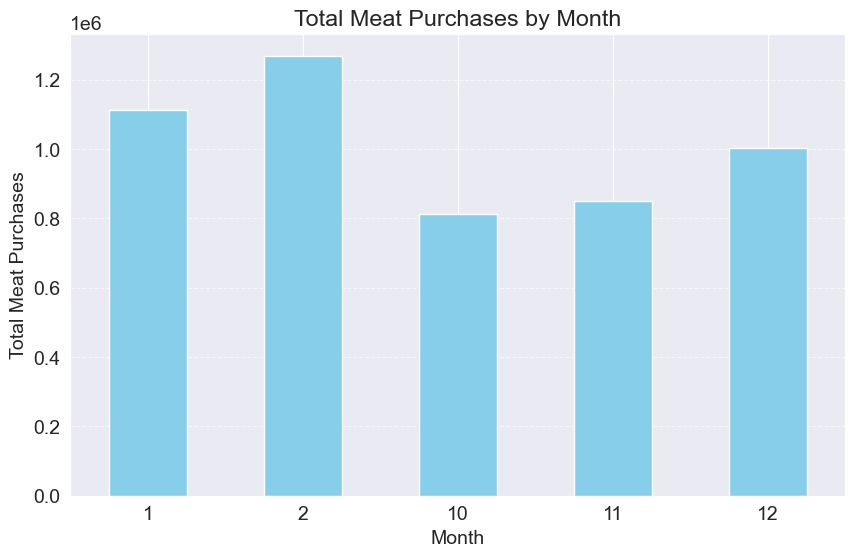

In [138]:
import matplotlib.pyplot as plt

# Calculate the total meat purchases for each month
total_meat_by_month = merged_df.groupby(merged_df['PURCHASE_DATE'].dt.month)['MEAT'].sum()

# Plot the total meat purchases by month
plt.figure(figsize=(10, 6))
total_meat_by_month.plot(kind='bar', color='skyblue')
plt.title('Total Meat Purchases by Month')
plt.xlabel('Month')
plt.ylabel('Total Meat Purchases')
plt.xticks(rotation=0)
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.show()


In [139]:
merged_df.PURCHASE_DATE.info()

<class 'pandas.core.series.Series'>
RangeIndex: 2455770 entries, 0 to 2455769
Series name: PURCHASE_DATE
Non-Null Count    Dtype         
--------------    -----         
2455770 non-null  datetime64[ns]
dtypes: datetime64[ns](1)
memory usage: 18.7 MB


In [140]:
merged_df.to_csv('merged_data_2.csv', index=False)

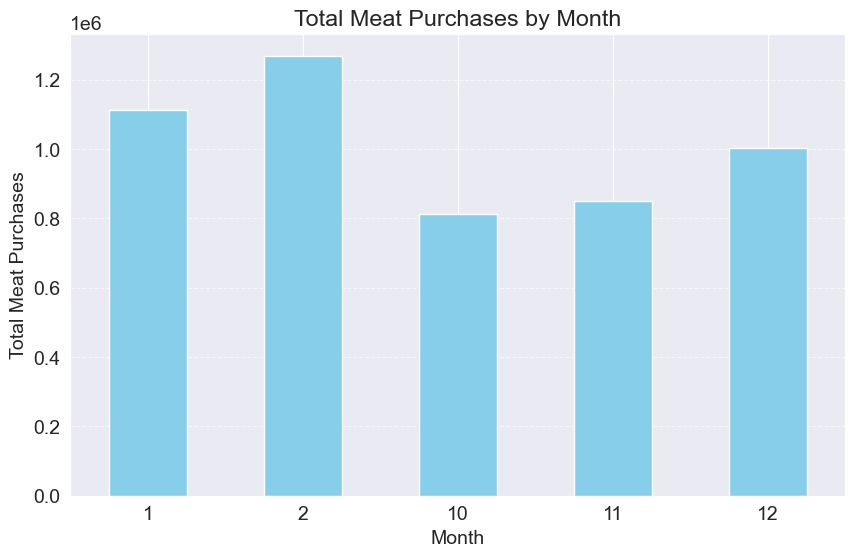

In [141]:
import matplotlib.pyplot as plt

# Calculate the total meat purchases for each month
total_meat_by_month = merged_df.groupby(merged_df['PURCHASE_DATE'].dt.month)['MEAT'].sum()

# Plot the total meat purchases by month
plt.figure(figsize=(10, 6))
total_meat_by_month.plot(kind='bar', color='skyblue')
plt.title('Total Meat Purchases by Month')
plt.xlabel('Month')
plt.ylabel('Total Meat Purchases')
plt.xticks(rotation=0)
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.show()


In [144]:
merged_df.columns

Index(['BOX_ID', 'QUALITY', 'DELIVERY_OPTION', 'MILK', 'MEAT', 'UNIT_PRICE',
       'PURCHASE_DATE', 'MAGIC_KEY', 'BOX_COUNT', 'TOTAL_MEAT',
       'PURCHASE_FREEQUENCY', 'DAY', 'MONTH', 'YEAR', 'OCT_MEAT', 'NOV_MEAT',
       'DEC_MEAT', 'JAN_MEAT', 'FEB_MEAT', '10_FIRST_PURCHASE_2018',
       '10_LAST_PURCHASE_2018', '11_FIRST_PURCHASE_2018',
       '11_LAST_PURCHASE_2018', '12_FIRST_PURCHASE_2018',
       '12_LAST_PURCHASE_2018', '01_FIRST_PURCHASE_2019',
       '01_LAST_PURCHASE_2019', '02_FIRST_PURCHASE_2019',
       '02_LAST_PURCHASE_2019', 'PURCHASE_DURATION', 'AVG_MEAT_PURCHASE',
       'PURCHASE_DAY_OF_WEEK', 'PREVIOUS_MEAT_QUANTITY', 'MEAT_MEAN',
       'MEAT_MEDIAN'],
      dtype='object')